In [73]:
#fetch_mldata is deprecated fetch_openml is the 

from sklearn.datasets import fetch_openml

import pandas as pd

# Load the MNIST dataset
mnist = fetch_openml(name='mnist_784', version=1, parser="auto")


In [74]:
X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

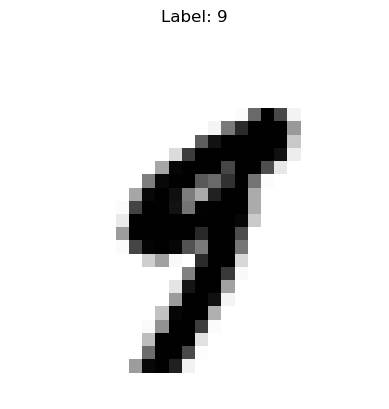

In [75]:
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt


# Get the features (pixel values) and labels from the dataset
# The Features must be convert to numpy array
X = mnist.data.to_numpy()
y = mnist.target

# Access the 36000th image and its corresponding label
image_index = 36000
image = X[image_index]
label = y[image_index]

# Reshape the image to its original 28x28 dimensions
image = image.reshape(28, 28)

# Display the image
plt.imshow(image, cmap='binary')
plt.axis('off')
plt.title(f"Label: {label}")
plt.show()


In [76]:
y[36000]

'9'

In [77]:
import numpy as np

#splitting the dataset to 60000 training set and 10000 testset
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
unique_classes = np.unique(y_train)
print("Unique classes in y_train:", unique_classes)

#shuffling dataset 
shuffled_index = np.random.permutation(60000) 
X_train, y_train = X_train[shuffled_index],y_train[shuffled_index]

X_train shape: (60000, 784)
y_train shape: (60000,)
Unique classes in y_train: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


## Training the binary classifier

In [78]:
# #converting y_train to interger
y_train = y_train.astype(int)

# Creating a target vector for binary classification
y_train_9 = (y_train == 9)
y_test_9 = (y_test ==  9)

# unique_classes = np.unique(y_train_9)
# print(unique_classes)

# Reshape `image` to a 1D array with shape (784,)
image = image.reshape(784)

from sklearn.linear_model import SGDClassifier

# Create SGDClassifier model
SGD_clf = SGDClassifier( random_state=42, max_iter=1000)

# Fit on training data
SGD_clf.fit(X_train, y_train_9)

# Make prediction
y_pred = SGD_clf.predict([image])

if y_pred[0] == 1:
  print("The image is a 9")
else:
  print("The image is not a 9")

The image is not a 9


## Perform cross validation

In [79]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import precision_score
# from sklearn.base import clone

# skfolds_model = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# # Initialize your model
# model = SGD_clf

# # Perform stratified cross-validation
# for train_index, test_index in skfolds_model.split(X, y):

#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     # Clone the model for each fold
#     cloned_model = clone(model)

#     # Train the cloned model using the training data
#     cloned_model.fit(X_train, y_train)

#     # Predict the target values for the test data
#     y_pred = cloned_model.predict(X_test)

#     # Calculate precision score
#     precision = precision_score(y_test, y_pred, average='micro')

#     # Print the precision score for each fold
#     print("Precision:", precision)

In [80]:
print(y_train_9)

28807    False
35555    False
46424    False
2110     False
27280    False
         ...  
47893    False
39373    False
21840     True
55950    False
3351     False
Name: class, Length: 60000, dtype: bool


## Performance Measure

* Using cross valadation (cross_val_score)
* cvscore shows a mean accuracy of 93%
* using a dumb classifier to verify the accuracy which confirm the cvscore with the model having more than 90% accuracy meaning 10% of the image are 9, 90% are not 9

In [81]:
from sklearn.model_selection import cross_val_score

cvscore = cross_val_score(SGD_clf, X_train, y_train_9, cv=3, scoring='accuracy')
print(cvscore)
cvscore.mean()


[0.94205 0.956   0.9497 ]


0.94925

In [82]:
from sklearn.base import BaseEstimator

class not9Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros(len(X), dtype=bool)
    
not_9_clf = not9Classifier()
cross_val_score(not_9_clf, X_train, y_train_9, cv=3, scoring='accuracy') 



array([0.8992 , 0.902  , 0.90135])

### Evaluationg using confusin matrix

In [83]:
from sklearn.model_selection import cross_val_predict

# this return the clean prediction on each test fold
y_train_pred = cross_val_predict(SGD_clf, X_train, y_train_9, cv=3) 

In [84]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_9, y_train_pred)

#TN of 50678 correctly classified as non 9s, FP- 3373 is wrongly classified as  9s
#FN of 752 wrongly classified as  non 9s, TP- 5195 is correctly classified as  9s

array([[52142,  1909],
       [ 1136,  4813]], dtype=int64)

In [85]:
confusion_matrix(y_train_9, y_train_pred)

array([[52142,  1909],
       [ 1136,  4813]], dtype=int64)

## Precision and recall as a metric

### The 9_detector does not look shine from it accuracy when it claimed that image represent 9 correctly only 70%. Moreover it only detect 78% of the 9s

In [86]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_9, y_train_pred)

0.7160071407319251

In [87]:
recall_score(y_train_9, y_train_pred)

0.809043536728862

In [88]:
from sklearn.metrics import f1_score

f1_score(y_train_9, y_train_pred, average='micro')

0.94925

## using a decison function to determine the right threshold to use

In [100]:

# y_scores= SGD_clf.decision_function([image])
# y_scores

array([-3242.12121675])

In [101]:
# threshold = 0
# y_score_image_pred = (y_scores > threshold)
# y_score_image_pred

array([False])

In [102]:
# threshold = 200000
# y_score_image_pred = (y_scores > threshold)
# y_score_image_pred

array([False])

In [103]:
# instead of using decision functions like above, we can use cross validation prediction with the method decision function

y_scores = cross_val_predict(SGD_clf, X_train, y_train_9, cv=3, method='decision_function')
y_scores

array([-25992.10943006,   5742.86474838, -26439.09265947, ...,
         3235.17485148, -30149.65921463,  -6516.29119984])

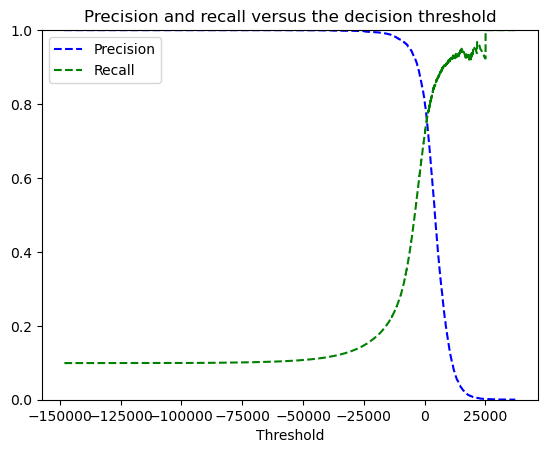

In [105]:
from sklearn.metrics import precision_recall_curve
recalls, precisions, thresholds = precision_recall_curve(y_train_9, y_scores)

def plot_precision_recall_vs_threshold(recalls, precisions, thresholds):
    plt.plot(thresholds, precisions[:-1],'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1],'g--', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc= 'upper left')
    plt.title('Precision and recall versus the decision threshold')
    plt.ylim([0, 1])
    plt.show()


plot_precision_recall_vs_threshold(recalls, precisions, thresholds)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


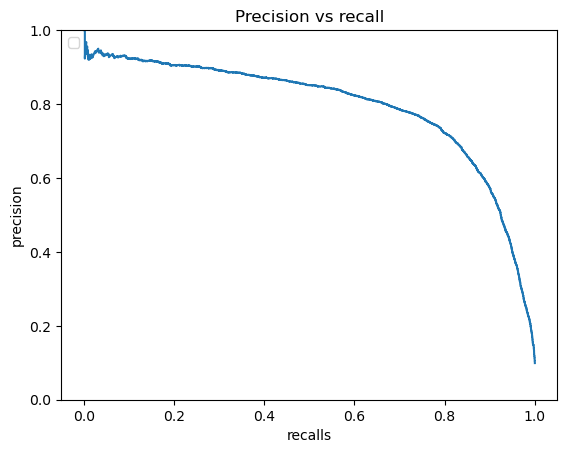

In [110]:
def plot_precision_vs_recall(recalls, precisions):
    plt.plot( precisions, recalls)
    plt.xlabel('recalls')
    plt.ylabel('precision')
    plt.legend(loc= 'upper left')
    plt.title('Precision vs recall')
    plt.ylim([0, 1])
    plt.show()
    
plot_precision_vs_recall(recalls, precisions)

In [121]:
y_train_pred_90 = (y_scores > 30000)
precision_score(y_train_9, y_train_pred_90)

1.0

In [122]:
recall_score(y_train_9, y_train_pred_90)

0.0006723819129265423